In [44]:
from urllib.request import urlretrieve
import zipfile, os

In [45]:
data_file_path = "data_manager_split_datasets/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)
    
if not os.path.exists(data_file_name):
    urlretrieve("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

In [46]:
data_file = zipfile.ZipFile(data_file_name)
URM_path = data_file.extract("ml-10M100K/ratings.dat", path=data_file_path + "decompressed/")
URM_file = open(URM_path, 'r')

In [47]:
type(URM_file)

_io.TextIOWrapper

In [48]:
import pandas as pd

In [49]:
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path,
                                sep='::',
                                header=None,
                                dtype={0:int, 1:int, 2:float, 3:int},
                                engine='python')
URM_all_dataframe.columns = ['UserID', 'ItemID', 'Interaction', 'Timestamp']

In [50]:
URM_all_dataframe.head()

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392


In [51]:
print("Number of items\t {}, Number of users\t {}".format(len(URM_all_dataframe['ItemID'].unique()), len(URM_all_dataframe['UserID'].unique())))
print("Number of interactions\t {}".format(URM_all_dataframe['Interaction'].count()))
print("Max value of UserID\t {}, Max value of ItemID\t {}".format(URM_all_dataframe['UserID'].max(), URM_all_dataframe['ItemID'].max()))

Number of items	 10677, Number of users	 69878
Number of interactions	 10000054
Max value of UserID	 71567, Max value of ItemID	 65133


In [52]:
mapped_id, original_id = pd.factorize(URM_all_dataframe['UserID'].unique())
user_original_ID_to_index = pd.Series(data=mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe['ItemID'].unique())
item_original_ID_to_index = pd.Series(data=mapped_id, index=original_id)

In [53]:
URM_all_dataframe['UserID'] = URM_all_dataframe['UserID'].map(user_original_ID_to_index)
URM_all_dataframe['ItemID'] = URM_all_dataframe['ItemID'].map(item_original_ID_to_index)

In [54]:
URM_all_dataframe.head(n=20)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [55]:
userID_unique = URM_all_dataframe['UserID'].unique()
itemID_unique = URM_all_dataframe['ItemID'].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print("Max value of UserID\t {}, Max value of ItemID\t {}".format(userID_unique.max(), itemID_unique.max()))
print("Number of interactions\t {}".format(n_interactions))

print("Average interactions per user {:.2f}\nAverage interactions per item {:.2f}".format(n_interactions/n_users, n_interactions/n_items))

print("Sparsity {:.2f} %".format((1 - n_interactions/(n_users*n_items))*100))

Number of items	 10677, Number of users	 69878
Max value of UserID	 69877, Max value of ItemID	 10676
Number of interactions	 10000054
Average interactions per user 143.11
Average interactions per item 936.60
Sparsity 98.66 %


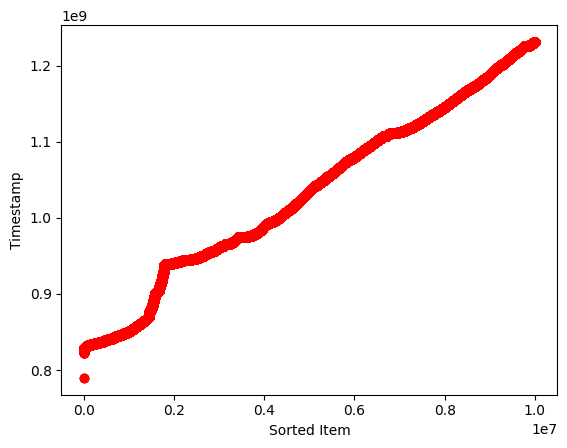

In [56]:
import matplotlib.pyplot as pyplot

timestamp_sorted = URM_all_dataframe['Timestamp'].values.copy()
timestamp_sorted.sort()

pyplot.plot(timestamp_sorted, 'ro')
pyplot.ylabel('Timestamp')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [57]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe['Interaction'].values, (URM_all_dataframe['UserID'].values, URM_all_dataframe['ItemID'].values)))
URM_all = URM_all.tocsr()

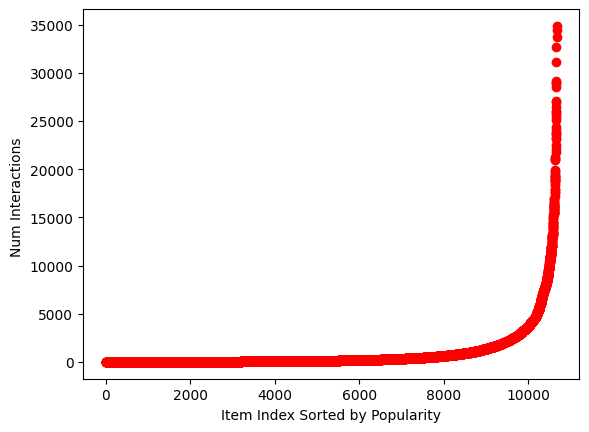

In [58]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity = np.sort(item_popularity)

pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Item Index Sorted by Popularity')
pyplot.show()

In [59]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}\n".format(item_popularity.mean()))
print("Average per-item interactions for the top 10% popular items {:.2f}\n".format(item_popularity[-ten_percent:].mean()))
print("Average per-item interactions for the least 10% popular items {:.2f}\n".format(item_popularity[:ten_percent].mean()))
print("Average per-item interactions for the median 10% popular items {:.2f}\n".format(item_popularity[int(n_items/2-ten_percent/2):int(n_items/2+ten_percent/2)].mean()))

Average per-item interactions over the whole dataset 936.60

Average per-item interactions for the top 10% popular items 6479.52

Average per-item interactions for the least 10% popular items 5.23

Average per-item interactions for the median 10% popular items 136.48


In [60]:
print("Number of items with zero interactions {} out of {}".format(np.sum(item_popularity==0), n_items))

Number of items with zero interactions 0 out of 10677


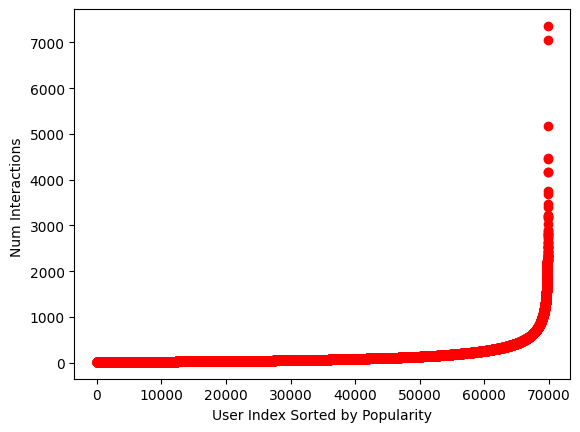

In [61]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)

pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('User Index Sorted by Popularity')
pyplot.show()

In [62]:
train_test_split = 0.8

n_interactions = URM_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

In [63]:
URM_all = URM_all.tocoo()
URM_train = sps.csr_matrix((URM_all.data[train_mask], (URM_all.row[train_mask], URM_all.col[train_mask])))

In [64]:
test_mask = np.logical_not(train_mask)
URM_test = sps.csr_matrix((URM_all.data[test_mask], (URM_all.row[test_mask], URM_all.col[test_mask])))

In [65]:
user_id = 124
relevant_items = URM_test[user_id].indices
recommended_items = np.array([241, 1622, 15, 857, 5823])
is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)

In [66]:
def precision(recommended_items, relevant_items):
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

In [67]:
def recall(recommended_items, relevant_items):
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

In [68]:
def average_precision(recommended_items, relevant_items):
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    precision_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    average_precision_score = np.sum(precision_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])
    return average_precision_score

In [69]:
class RandomRecommender(object):
    def fit(self, URM_train):
        self.n_items = URM_train.shape[1]
        
    def recommend(self, user_id, at=10):
        recommended_items = np.random.choice(self.n_items, at)
        return recommended_items

In [70]:
random_recommender = RandomRecommender()
random_recommender.fit(URM_train)

for user_id in range(10):
    print("Recommendations for user_id {}".format(user_id))
    print(random_recommender.recommend(user_id, at=5))

Recommendations for user_id 0
[5490 4167 8750 2918 2625]
Recommendations for user_id 1
[9014 2507 3534 8173 8927]
Recommendations for user_id 2
[4470 2973 9967 5382 1393]
Recommendations for user_id 3
[6735 6534 8803 5048 8149]
Recommendations for user_id 4
[4760 8952 6306 5283 7639]
Recommendations for user_id 5
[ 2910 10561  2820  9546  9060]
Recommendations for user_id 6
[5879 7831 2276 3777 8851]
Recommendations for user_id 7
[2636 8505 7313 8730 5667]
Recommendations for user_id 8
[3749 4351 5100 7519 4243]
Recommendations for user_id 9
[6560 5529 1717   33 3859]


In [71]:
def evaluate_algorithm(URM_test, recommender_object, at=5):
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0
    
    URM_test = sps.csr_matrix(URM_test)
    
    for user_id in range(URM_test.shape[0]):
        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            recommended_items = recommender_object.recommend(user_id, at=at)
            
            num_eval+=1
            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += average_precision(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender performance is: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(cumulative_precision, cumulative_recall, MAP))

In [72]:
evaluate_algorithm(URM_test, random_recommender)

Recommender performance is: Precision = 0.0028, Recall = 0.0005, MAP = 0.0013


In [73]:
class TopPopRecommender(object):
    def fit(self, URM_train):
        item_popularity = np.ediff1d(URM_train.tocsc().indptr)
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis=0)

    def recommend(self, user_id, at=5):
        recommended_items = self.popular_items[0:at]
        return recommended_items

In [74]:
top_pop_recommender = TopPopRecommender()
top_pop_recommender.fit(URM_train)

for user_id in range(10):
    print("Recommendations for user_id {}".format(user_id))
    print(top_pop_recommender.recommend(user_id, at=5))

Recommendations for user_id 0
[1008    7  139   14 1293]
Recommendations for user_id 1
[1008    7  139   14 1293]
Recommendations for user_id 2
[1008    7  139   14 1293]
Recommendations for user_id 3
[1008    7  139   14 1293]
Recommendations for user_id 4
[1008    7  139   14 1293]
Recommendations for user_id 5
[1008    7  139   14 1293]
Recommendations for user_id 6
[1008    7  139   14 1293]
Recommendations for user_id 7
[1008    7  139   14 1293]
Recommendations for user_id 8
[1008    7  139   14 1293]
Recommendations for user_id 9
[1008    7  139   14 1293]


In [75]:
evaluate_algorithm(URM_test, top_pop_recommender, at=5)

Recommender performance is: Precision = 0.0955, Recall = 0.0309, MAP = 0.0526


In [76]:
class TopPopRecommenderRemoved(object):
    def fit(self, URM_train):
        self.URM_train = URM_train
        item_popularity = np.ediff1d(URM_train.tocsc().indptr)
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis=0)

    def recommend(self, user_id, at=5, remove_seen=True):
        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id + 1]]
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert=True)
            unseen_items = self.popular_items[unseen_items_mask]
            recommended_items = unseen_items[0:at]
        else:
            recommended_items = self.popular_items[0:at]
        return recommended_items

In [77]:
top_pop_recommender_removed = TopPopRecommenderRemoved()
top_pop_recommender_removed.fit(URM_train)

for user_id in range(10):
    print("Recommendations for user_id {}".format(user_id))
    print(top_pop_recommender_removed.recommend(user_id, at=5))

Recommendations for user_id 0
[1008  139 1293   22  175]
Recommendations for user_id 1
[1008    7  139   14 1293]
Recommendations for user_id 2
[1008    7  139   14 1293]
Recommendations for user_id 3
[1008    7  139 1293  175]
Recommendations for user_id 4
[1008    7   14 1293   22]
Recommendations for user_id 5
[1008    7  139   14 1293]
Recommendations for user_id 6
[1008    7   14 1293   22]
Recommendations for user_id 7
[1008    7 1293   22   24]
Recommendations for user_id 8
[1008    7  139   14 1293]
Recommendations for user_id 9
[   7   14 1293   22   19]


In [78]:
evaluate_algorithm(URM_test, top_pop_recommender_removed)

Recommender performance is: Precision = 0.1980, Recall = 0.0531, MAP = 0.1468


In [79]:
global_average = np.mean(URM_train.data)
print("The global average is {:.2f}".format(global_average))

The global average is 3.51


In [80]:
URM_train_unbiased = URM_train.copy()
URM_train_unbiased.data -= global_average
print(URM_train_unbiased.data[0:10])

[1.48749946 1.48749946 1.48749946 1.48749946 1.48749946 1.48749946
 1.48749946 1.48749946 1.48749946 1.48749946]


In [81]:
lambda_item = 25
lambda_user = 10
col_nnz = np.ediff1d(sps.csc_matrix(URM_train_unbiased).indptr)
item_mean_rating = URM_train_unbiased.sum(axis=0) / (col_nnz + lambda_item)
item_mean_rating = np.asarray(item_mean_rating).ravel()
item_mean_rating[col_nnz==0] = -np.inf
item_mean_rating

array([-0.63036037, -0.38615034, -0.56985744, ..., -0.01944448,
       -0.0581731 ,  0.01874998])

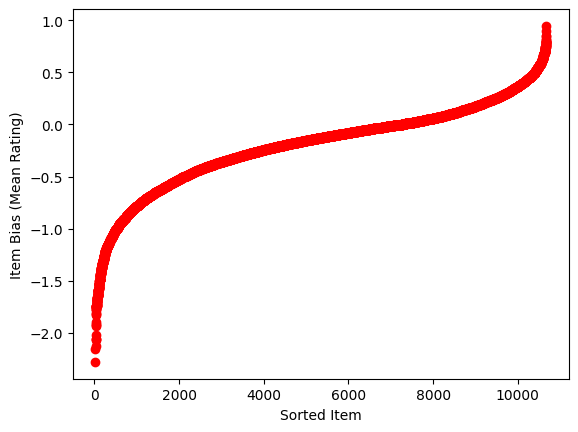

In [82]:
item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating != 0])

pyplot.plot(item_mean_rating, 'ro')
pyplot.ylabel('Item Bias (Mean Rating)')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [83]:
row_nnz = np.ediff1d(sps.csr_matrix(URM_train_unbiased).indptr)
user_mean_rating = URM_train_unbiased.sum(axis=1).ravel() / (row_nnz + lambda_user)
user_mean_rating = np.asarray(user_mean_rating).ravel()
user_mean_rating[row_nnz==0] = -np.inf
user_mean_rating

array([ 0.95624965, -0.24861145,  0.26874961, ...,  0.40118998,
        0.22474447, -0.31383973])

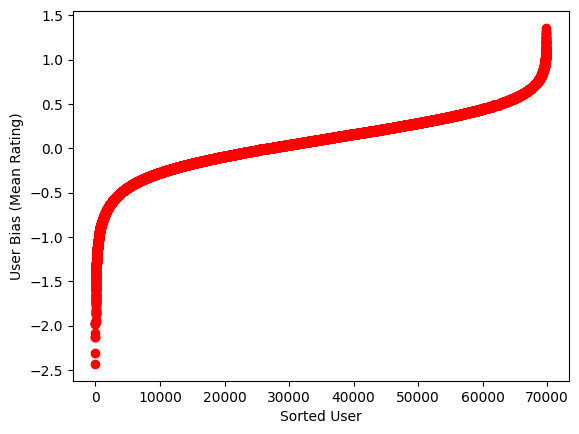

In [84]:
user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating != 0])

pyplot.plot(user_mean_rating, 'ro')
pyplot.ylabel('User Bias (Mean Rating)')
pyplot.xlabel('Sorted User')
pyplot.show()

In [85]:
class GlobalEffectsRecommender(object):

    def fit(self, URM_train, lambda_user=10, lambda_item=25):
        
        self.URM_train = URM_train

        self.mu = self.URM_train.data.sum(dtype=np.float32) / self.URM_train.nnz

        col_nnz = np.ediff1d(sps.csc_matrix(self.URM_train).indptr)

        URM_train_unbiased = self.URM_train.copy()
        URM_train_unbiased.data -= self.mu
        
        item_bias = URM_train_unbiased.sum(axis=0) / (col_nnz + lambda_item)
        item_bias = np.asarray(item_bias).ravel()
        item_bias[col_nnz==0] = -np.inf 
        
        self.bestRatedItems = np.argsort(item_bias)
        self.bestRatedItems = np.flip(self.bestRatedItems, axis = 0)
        
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.bestRatedItems, seen_items, assume_unique=True, invert = True)

            unseen_items = self.bestRatedItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.bestRatedItems[0:at]
            

        return recommended_items

In [86]:
globalEffectsRecommender = GlobalEffectsRecommender()
globalEffectsRecommender.fit(URM_train)

evaluate_algorithm(URM_test, globalEffectsRecommender)

Recommender performance is: Precision = 0.0760, Recall = 0.0188, MAP = 0.0546


In [87]:
for rating_threshold in range(0, 5):
    
    print("Removing ratings <= {}".format(rating_threshold))
    
    URM_train_filtered = URM_train.copy()
    URM_train_filtered.data[URM_train.data <= rating_threshold] = 0
    
    URM_train_filtered.eliminate_zeros()
    
    top_pop_recommender = TopPopRecommender()
    top_pop_recommender.fit(URM_train_filtered)
    
    evaluate_algorithm(URM_test, top_pop_recommender)

Removing ratings <= 0
Recommender performance is: Precision = 0.0955, Recall = 0.0309, MAP = 0.0526
Removing ratings <= 1
Recommender performance is: Precision = 0.0955, Recall = 0.0309, MAP = 0.0522
Removing ratings <= 2
Recommender performance is: Precision = 0.0955, Recall = 0.0309, MAP = 0.0522
Removing ratings <= 3
Recommender performance is: Precision = 0.0927, Recall = 0.0296, MAP = 0.0503
Removing ratings <= 4
Recommender performance is: Precision = 0.0880, Recall = 0.0274, MAP = 0.0479


In [ ]:
class UserCBFKNNRecommender(object):